In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load Data

In [22]:
# Load dataset
data = pd.read_csv('../data/salary_data_clean.csv')

## Create tensors

In [23]:
X = data.drop(columns=['Salary','Job Title'], axis=1)  
y = data['Salary'].values
job_title = data['Job Title'].values

In [24]:
# Por ejemplo, primero 80% train_val, 20% test
X_train_val, X_test, job_title_train_val, job_title_test, y_train_val, y_test = train_test_split(
    X, job_title, y, test_size=0.2, random_state=42
)

# Luego, dentro del train_val, reservar 25% para validación
X_train, X_val, job_title_train, job_title_val, y_train, y_val = train_test_split(
    X_train_val, job_title_train_val, y_train_val, test_size=0.25, random_state=42
)

In [25]:
# Escalar únicamente las variables numéricas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [26]:
# Convertir cada parte a tensores

# -- Tensores numéricos --
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)

# -- Tensores de la variable categórica (dtype long) --
job_title_train_tensor = torch.tensor(job_title_train, dtype=torch.long)
job_title_val_tensor   = torch.tensor(job_title_val,   dtype=torch.long)
job_title_test_tensor  = torch.tensor(job_title_test,  dtype=torch.long)

# -- Tensores del target --
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.float32).view(-1, 1)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)


# Modeling

In [27]:
# Definir el modelo de red neuronal
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(13, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
class RegressionEmbeddingNN(nn.Module):
    NUM_FEATURES = 13
    NUM_JOB_TITLES = 191
    EMBEDDING_DIMENSIONS = 10


    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=self.NUM_JOB_TITLES, embedding_dim=self.EMBEDDING_DIMENSIONS)
        
        self.fc1 = nn.Linear(self.NUM_FEATURES + self.EMBEDDING_DIMENSIONS - 1, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

        self.relu = nn.ReLU()

    def forward(self, x, x_job_title):
        emb = self.embedding(x_job_title)
        emb = emb.view(emb.size(0), -1)  
        x = torch.cat([x, emb], dim=1)  # concatenamos

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:

# Inicializar modelo, pérdida y optimizador
# model = RegressionNN()
model = RegressionEmbeddingNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch [50000/50000] Train Loss: 327139936.0000 Val Loss: 593719616.0000


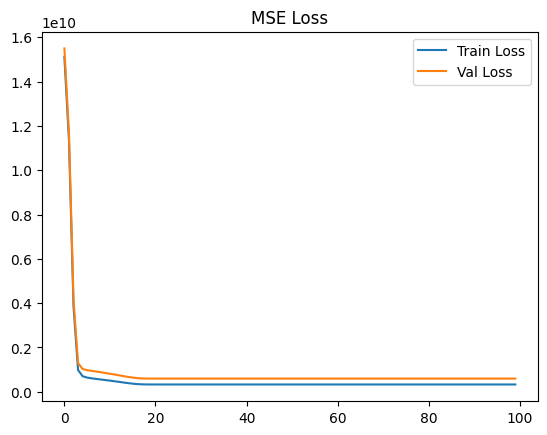

In [38]:
# Entrenamiento del modelo
epochs = 50000  # Ajusta según tu caso
log_interval = 500

train_loss_values = []
val_loss_values = []


for epoch in range(epochs):
    # --- TRAIN PHASE ---
    model.train()
    optimizer.zero_grad()

    # 1) Forward (asegúrate de pasar las 2 entradas: X, job_title)
    # predictions = model(X_train_tensor)
    predictions = model(X_train_tensor, job_title_train_tensor)
    
    # 2) Cálculo de la pérdida en entrenamiento
    train_loss = criterion(predictions, y_train_tensor)

    # 3) Backprop
    train_loss.backward()

    # 4) Actualización de parámetros
    optimizer.step()
    
    # --- VALIDATION PHASE (cada X iteraciones) ---
    if (epoch + 1) % log_interval == 0:
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_tensor, job_title_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        # Almaceno valores de pérdida para gráficas
        train_loss_values.append(train_loss.item())
        val_loss_values.append(val_loss.item())

        # Mostrar progreso
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss.item():.4f} "
              f"Val Loss: {val_loss.item():.4f}")

        # (Opcional) Gráfica de pérdidas en tiempo real
        fig = plt.figure()
        plt.plot(train_loss_values, label='Train Loss')
        plt.plot(val_loss_values, label='Val Loss')
        plt.legend()
        plt.title("MSE Loss")
        plt.show()
        clear_output(wait=True)

In [39]:

# Evaluación del modelo
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor, job_title_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 813944128.0000


## Evaluación